# About This Notebook
this is copy of [NooBHound's Notebook](https://www.kaggle.com/code/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl/notebook) on [mercari price suggestion challenge competition](https://www.kaggle.com/competitions/mercari-price-suggestion-challenge) __But in Korean__

# Import libraries, Load Datafile

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import math
from subprocess import check_output



## Extracting datafile - required only once for session

In [20]:
#!p7zip -d ../input/mercari-price-suggestion-challenge/train.tsv.7z /kaggle/working/

In [21]:
#!p7zip -d ../input/mercari-price-suggestion-challenge/test.tsv.7z /kaggle/working/
#!p7zip -d ../input/mercari-price-suggestion-challenge/sample_submission.csv.7z /kaggle/working/

__assert__
자기주장을 확고히 한다는 뜻.
```python
assert condition, string
```
은 condition이 False이면 string을 출력하고 에러를 일으킨다. 조건문을 보증하는 것

In [22]:
# for debug...
num_rows = None #for test. set None to process whole data. It does not work with num_rows = 30000. Don't know why

In [23]:
def rmsle(y, y_pred):
    """
    rmsle(y, y_pred).
    return root mean squared log error(rmsle) with both array, assert two array have same length
    source: https://www.kaggle.com/marknagelberg/rmsle-function
    """
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i, pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
print('loading data...')
path = '/kaggle/working'
train = pd.read_table(path + '/train.tsv', nrows=num_rows)
test = pd.read_table(path + '/test.tsv', nrows = num_rows)
print(train.shape)
print(test.shape)


loading data...
(1482535, 8)
(693359, 7)


# Missing values에 대한 처리

In [24]:
print('handling missing values')
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace = True)
    dataset.brand_name.fillna(value="missing", inplace = True)
    dataset.item_description.fillna(value="missing", inplace = True)
    return dataset

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

handling missing values
(1482535, 8)
(693359, 7)


In [25]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity


# Process Categorical Data
categorical features written in string datatype. encode as integers.

In [26]:
print("handling categorical features...")
le = LabelEncoder()
le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head(3)

handling categorical features...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


# Process Text : Raw

In [27]:
print("Text to seq converting...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])
print("\tFitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("\tTransforming text to seq... ")
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head(3)

Text to seq converting...
	Fitting tokenizer...
	Transforming text to seq... 


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


# Sequences Variables Analysis

In [28]:

_name_seq = np.max([np.max(train.seq_name.apply(len)), np.max(test.seq_name.apply(len))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(len)), np.max(test.seq_item_description.apply(len))])
print('max name seq ', str(max_name_seq))
print('max item desc seq '+str(max_seq_item_description))


max name seq  17
max item desc seq 269


<AxesSubplot:>

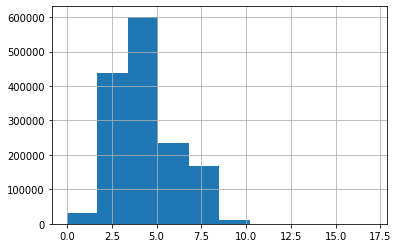

In [29]:
train.seq_name.apply(len).hist()

<AxesSubplot:>

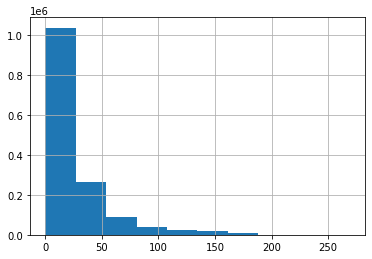

In [30]:
train.seq_item_description.apply(len).hist()

# Embbeding Max Values
히스토그램을 바탕으로 다음 길이들을 정하였다.

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

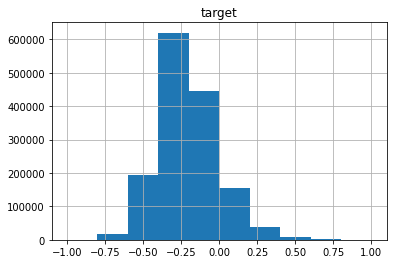

In [31]:
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max()),
                  np.max(test.seq_name.max()),
                  np.max(train.seq_item_description.max()),
                  np.max(test.seq_item_description.max())])+2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1
#Q) why add 1 or 2?
#Scale target variable
train['target'] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train['target'] = target_scaler.fit_transform(train.target.values.reshape(-1,1))
pd.DataFrame(train.target).hist()

### Extract Development Test

In [32]:
dtrain, dvalid = train_test_split(train, random_state = 123, train_size = 0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


# Keras Data Definition
build model

In [33]:
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {'name':pad_sequences(dataset.seq_name, maxlen = MAX_NAME_SEQ),
        'item_desc':pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
        'brand_name':np.array(dataset.brand_name),
        'category_name':np.array(dataset.category_name),
        'item_condition':np.array(dataset.item_condition_id),
        'num_vars':np.array(dataset[['shipping']])}
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)
#Keras Model Definition
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience = 2):
    es = EarlyStopping('val_loss', patience = patience, mode='min')
    msave = ModelChekpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.0)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #inputs
    name = Input(shape=[X_train['name'].shape[1]], name='name')
    item_desc = Input(shape=[X_train['item_desc'].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name = "item_condition")
    num_vars = Input(shape = [X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embedding layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten()(emb_brand_name),
        Flatten()(emb_category_name),
        Flatten()(emb_item_condition),
        rnn_layer1,
        rnn_layer2,
        num_vars
    ])
    main_l = Dropout(dr_r)(Dense(128) (main_l))
    main_l = Dropout(dr_r)(Dense(128) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name,
                  category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    return model
model = get_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          [(None, 75)]         0                                            
____________________________________________________________________________________________

# Fitting the model (Training)

In [34]:
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE,
         validation_data=(X_valid, dvalid.target),
         verbose=1)

Epoch 1/5
74/74 [==============================] - 137s 2s/step - loss: 0.0283 - mae: 0.1278 - rmsle_cust: 0.0154 - val_loss: 0.0181 - val_mae: 0.1020 - val_rmsle_cust: 0.0135
Epoch 2/5
74/74 [==============================] - 128s 2s/step - loss: 0.0180 - mae: 0.1015 - rmsle_cust: 0.0133 - val_loss: 0.0162 - val_mae: 0.0962 - val_rmsle_cust: 0.0128
Epoch 3/5
74/74 [==============================] - 121s 2s/step - loss: 0.0159 - mae: 0.0954 - rmsle_cust: 0.0126 - val_loss: 0.0154 - val_mae: 0.0945 - val_rmsle_cust: 0.0124
Epoch 4/5
74/74 [==============================] - 119s 2s/step - loss: 0.0147 - mae: 0.0918 - rmsle_cust: 0.0122 - val_loss: 0.0152 - val_mae: 0.0938 - val_rmsle_cust: 0.0123
Epoch 5/5
74/74 [==============================] - 120s 2s/step - loss: 0.0141 - mae: 0.0896 - rmsle_cust: 0.0119 - val_loss: 0.0153 - val_mae: 0.0935 - val_rmsle_cust: 0.0124


In [35]:
#Evaluate the model on DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:, 0]
v_rmsle = rmsle(y_true, y_pred)
print("  RMSLE error on dev test: "+str(v_rmsle))


  RMSLE error on dev test: 0.48091512411645077


In [36]:
# Create Predictions
preds = model.predict(X_test, batch_size = BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<AxesSubplot:>

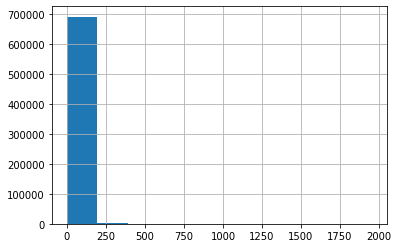

In [37]:
submission.to_csv("./myNNsubmission.csv", index=False)
submission.price.hist()

# 맺음말
이것은 신경망이 이 문제를 어떻게 푸는 지에 대한 예였고, 다음과 같은 식으로 커널이 더 좋아질 수도 있다.
- embedding 팩터 늘리기
- BATCH SIZE줄이기
- Batch Normalization 넣기
- LSTM, Bidirectional RNN, stack RNN등으로 해보기
- RNN아웃풋을 추가하거나 Dense Layer 추가해보기
- 아예 다른 구조를 해보기